In [1]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
import time
import librosa
import libfmp.c3
from numba import jit

# Testando a velocidade de funções DTW:

# Codígo python:

In [2]:
def DTW(sinal_1,sinal_2):
    #transformando o sinal em um array, caso seja dado uma lista
    sinal_1=np.array(sinal_1)
    sinal_2=np.array(sinal_2)
    
    #calculando a distancia entre cada amostra de um sinal ao outra:
    N = sinal_1.shape[0]
    M = sinal_2.shape[0]
    matriz_distancia = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            matriz_distancia[i, j] = abs(sinal_1[i] - sinal_2[j])
    
    # Iniciando a matriz de custo: (infinito pois não existe distancia entre o sinal e ele mesmo)
    matriz_custo = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        matriz_custo[i, 0] = np.inf
    for i in range(1, M + 1):
        matriz_custo[0, i] = np.inf

    # A parte mais importante está aqui: calculamos a matriz de custo mas criamos uma matriz auxiliar
    # que carrega informações sobre qual posição o custo veio
    optimal_warping_path  = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            custo_anterior = [
                matriz_custo[i, j],   #as amostras possuem tamanhos iguais
                matriz_custo[i, j + 1], #adicionamos um caminho a uma amostra não esta alinhada porem possuem o mesmo valor
                matriz_custo[i + 1, j]] #removemos uma amostra que não está alinhada pois iria um valor
            i_custo_anterior = np.argmin(custo_anterior)
            matriz_custo[i + 1, j + 1] = matriz_distancia[i, j] + custo_anterior[i_custo_anterior]
            optimal_warping_path[i, j] = i_custo_anterior

    # traçando o caminho da origem:
    i = N - 1
    j = M - 1
    caminho = [(i, j)]
    while i > 0 or j > 0:
        OWT_tipo = optimal_warping_path[i, j]
        if OWT_tipo == 0:
            # iguais
            i = i - 1
            j = j - 1
        elif OWT_tipo == 1:
            # Adiciona
            i = i - 1
        elif OWT_tipo == 2:
            # Deleta
            j = j - 1
        caminho.append((i, j))

    # removendo infinito da matriz de custo:
    matriz_custo = matriz_custo[1:, 1:]
    return (matriz_distancia,caminho[::-1], matriz_custo)

Agora vamos comparar o tempo de execução de cada um desses programas, para sinais de ordem $10$ a $10^4$.

# Python:

In [3]:
np.random.seed(42)
tempo_python=[]
for i in range(1,5):
    sinal_1 = np.random.randint(-10, 11, 10**i)
    sinal_2 = np.random.randint(-10, 11, 10**i)
    tempo_inicial = time.time()
    DTW(sinal_1,sinal_2)
    tempo_final = time.time()
    tempo_python.append(tempo_final-tempo_inicial)

# Limbfmp:

In [4]:
tempo_libfmp=[]
for i in range(1,5):
    sinal_1 = np.random.randint(-10, 11, 10**i)
    sinal_2 = np.random.randint(-10, 11, 10**i)
    tempo_inicial = time.time()
    C = libfmp.c3.compute_cost_matrix(sinal_1, sinal_2)
    D = libfmp.c3.compute_accumulated_cost_matrix(C)
    P = libfmp.c3.compute_optimal_warping_path(D)
    tempo_final = time.time()
    tempo_libfmp.append(tempo_final-tempo_inicial)

# Librosa:

In [5]:
tempo_librosa=[]
for i in range(1,5):
    sinal_1 = np.random.randint(-10, 11, 10**i)
    sinal_2 = np.random.randint(-10, 11, 10**i)
    tempo_inicial = time.time()
    D, P = librosa.sequence.dtw(sinal_1, sinal_2, metric='euclidean', 
                            step_sizes_sigma=np.array([[1, 1], [0, 1], [1, 0]]),
                            weights_add=np.array([0, 0, 0]), weights_mul=np.array([1, 1, 1]))
    tempo_final = time.time()
    tempo_librosa.append(tempo_final-tempo_inicial)

# Código python com numba:

In [6]:
from numba import jit, njit
import numpy as np

@njit
def compute_i_custo_anterior(custo_anterior):
    i_custo_anterior = 0
    min_custo_anterior = custo_anterior[0]
    for k in range(1, 3):
        if custo_anterior[k] < min_custo_anterior:
            i_custo_anterior = k
            min_custo_anterior = custo_anterior[k]
    return i_custo_anterior

@jit(nopython=True)
def DTW_C(sinal_1, sinal_2):
    N = sinal_1.shape[0]
    M = sinal_2.shape[0]
    matriz_distancia = np.zeros((N, M))

    for i in range(N):
        for j in range(M):
            matriz_distancia[i, j] = abs(sinal_1[i] - sinal_2[j])

    matriz_custo = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        matriz_custo[i, 0] = np.inf
    for i in range(1, M + 1):
        matriz_custo[0, i] = np.inf

    optimal_warping_path = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            custo_anterior = [
                matriz_custo[i, j],
                matriz_custo[i, j + 1],
                matriz_custo[i + 1, j]
            ]
            i_custo_anterior = compute_i_custo_anterior(custo_anterior)
            matriz_custo[i + 1, j + 1] = matriz_distancia[i, j] + custo_anterior[i_custo_anterior]
            optimal_warping_path[i, j] = i_custo_anterior

    i = N - 1
    j = M - 1
    caminho = [(i, j)]
    while i > 0 or j > 0:
        OWT_tipo = optimal_warping_path[i, j]
        if OWT_tipo == 0:
            i = i - 1
            j = j - 1
        elif OWT_tipo == 1:
            i = i - 1
        elif OWT_tipo == 2:
            j = j - 1
        caminho.append((i, j))

    matriz_custo = matriz_custo[1:, 1:]
    return (matriz_distancia, caminho[::-1], matriz_custo)

In [7]:
np.random.seed(42)
tempo_python_c=[]
for i in range(1,5):
    sinal_1 = np.random.randint(-10, 11, 10**i)
    sinal_2 = np.random.randint(-10, 11, 10**i)
    tempo_inicial = time.time()
    DTW_C(sinal_1,sinal_2)
    tempo_final = time.time()
    tempo_python_c.append(tempo_final-tempo_inicial)

# Grafico do tempo de resolução:

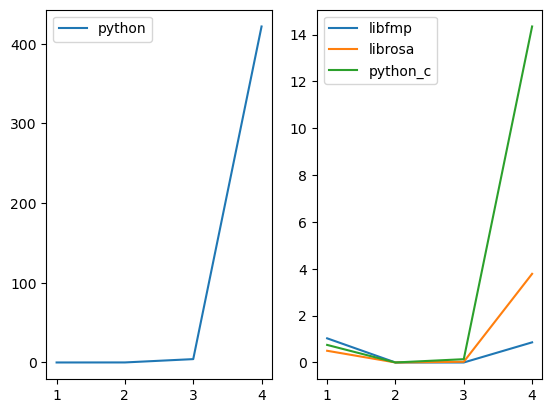

In [13]:
valores_n = [1,2,3,4]
fig,(x1,x2)=plt.subplots(1,2)
x1.plot(valores_n, tempo_python, label = "python")
x2.plot(valores_n, tempo_libfmp, label = "libfmp")
x2.plot(valores_n, tempo_librosa, label = "librosa")
x2.plot(valores_n, tempo_python_c, label = "python_c")
x1.legend()
x2.legend()